In [ ]:
# We assume that PyTorch is already installed
import torch

# Visualization
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Identity
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GINConv, SAGEConv, GATConv
from torch_geometric.nn import global_mean_pool, global_add_pool

from  sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd


import seaborn as sns
sns.set_style("ticks")

dataset = TUDataset(root='.', name='NCI1')

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [3]:
def smooth_plot(x, y=None, ax=None, label='', halflife=10):

    """ 
    Function to plot smoothed x VS y graphs.

    Parameters:	
    ----------

    x - x-axis data.
    y - y-axis data.
    label - Legend for the current graph.
    halflife - Smoothing level.

    ----------

    Yields:	x VS y graphs.

    ----------
    """

    if y is None:
      y_int = x
    else:
      y_int = y
    
    x_ewm = pd.Series(y_int).ewm(halflife=halflife)
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    if y is None:
      ax.plot(x_ewm.mean(), label=label, color=color)
      ax.fill_between(np.arange(x_ewm.mean().shape[0]), x_ewm.mean() + x_ewm.std(), x_ewm.mean() - x_ewm.std(), color=color, alpha=0.15)
    else:
      ax.plot(x, x_ewm.mean(), label=label, color=color)
      ax.fill_between(x, y_int + x_ewm.std(), y_int - x_ewm.std(), color=color, alpha=0.15)

In [2]:
def get_resistances(graph, reference_node):
    resistances = {}
    
    for node in graph.nodes:
        if node != reference_node:
            resistances[node] = round(nx.resistance_distance(graph, reference_node, node),3)
        else:
            resistances[node] = 0
    return resistances

In [4]:
class Net(torch.nn.Module):
    def __init__(self, arch, num_layers, dim_h):
        super(Net, self).__init__()

        name2arch = {'gcn': GCNConv, 'sage': SAGEConv, 'gat': GATConv, 'gin': GINConv}

        module_list = []
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
          if arch != 'gin':
            self.convs.append(
                Sequential(name2arch[arch](dim_h if i != 0 else dataset.num_node_features, dim_h, bias=False, root_weight=False),
                           Identity(dim_h),
                          ReLU()
                          )
            )

          elif arch == 'gin':
            self.convs.append(GINConv( Sequential(
                                                  Linear(dim_h if i != 0 else dataset.num_node_features, dim_h, bias=False),
                                                  Identity(dim_h), ReLU(),
                                                  Linear(dim_h, dim_h, bias=False), 
                                                  ReLU()
                                                 )
                                     )
                             )

        self.arch = arch
        
    def forward(self, G):
        h, edge_index = G.x, G.edge_index
        for conv in self.convs:
          if self.arch == 'gin':
            h = conv(h, edge_index)
          else:
            for op in conv:
              try: 
                h = op(h, edge_index)
              except:
                h = op(h)
        return h


In [ ]:

pairs_gin_runaway = []
pairs_sage_runaway = []
pairs_gcn_runaway = []
pairs_gat_runaway = []


pairs_gin = []
pairs_sage = []
pairs_gcn = []
pairs_gat = []

diameters = []

num_verteces_sampled = 10

for i in range(len(dataset)):
  try:
    G = to_networkx(dataset[i], to_undirected=True)
    diameters.append(nx.diameter(G))
    distances = nx.floyd_warshall_numpy(G)

    pairs_gin_runaway = []
    pairs_sage_runaway = []
    pairs_gcn_runaway = []
    pairs_gat_runaway = []

    for _ in range(num_verteces_sampled):

      gin = Net(arch='gin', num_layers=10, dim_h=5)
      sage = Net(arch='sage', num_layers=10, dim_h=5)
      gcn = Net(arch='gcn', num_layers=10, dim_h=5)
      gat = Net(arch='gat', num_layers=10, dim_h=5)
      source = np.random.randint(0, len(G)) #pick a source node

      max_t_A_st = distances[source].max()

      x = torch.zeros_like(dataset[i].x) #put zero almost everywhere
      x[source] = torch.randn_like(dataset[i].x[source]) #set random mass
      x[source] = x[source].softmax(dim=-1) #normalize to unitary positive mass on the source node
      dataset[i].x.data = x #set that feature matrix

      out_gin = gin(dataset[i])
      out_gin = (out_gin / out_gin.sum()).cpu().detach().numpy()
      out_gin = np.nan_to_num(out_gin, copy=True, nan=0.0, posinf=None, neginf=None)

      out_sage = sage(dataset[i])
      out_sage = (out_sage / out_sage.sum()).cpu().detach().numpy()
      out_sage = np.nan_to_num(out_sage, copy=True, nan=0.0, posinf=None, neginf=None)

      out_gcn = gcn(dataset[i])
      out_gcn = (out_gcn / out_gcn.sum()).cpu().detach().numpy()
      out_gcn = np.nan_to_num(out_gcn, copy=True, nan=0.0, posinf=None, neginf=None)

      out_gat = gat(dataset[i])
      out_gat = (out_gat / out_gat.sum()).cpu().detach().numpy()
      out_gat = np.nan_to_num(out_gat, copy=True, nan=0.0, posinf=None, neginf=None)

      acc_gin = 0.0
      acc_sage = 0.0
      acc_gcn = 0.0
      acc_gat = 0.0
      for j in range(len(out_gin)):
        acc_gin += out_gin[j] * distances[j, source]
        acc_sage += out_sage[j] * distances[j, source]
        acc_gcn += out_gcn[j] * distances[j, source]
        acc_gat += out_gat[j] * distances[j, source]


      propagation_gin = ((1/max_t_A_st) * acc_gin).mean()
      propagation_sage = ((1/max_t_A_st) * acc_sage).mean()
      propagation_gcn = ((1/max_t_A_st) * acc_gcn).mean()
      propagation_gat = ((1/max_t_A_st) * acc_gat).mean()

      total_effective_resistance = sum(get_resistances(G, source).values())
      
      x_y_gin = (total_effective_resistance, propagation_gin)
      x_y_sage = (total_effective_resistance, propagation_sage)
      x_y_gcn = (total_effective_resistance, propagation_gcn)
      x_y_gat = (total_effective_resistance, propagation_gat)


      pairs_gin_runaway.append(x_y_gin)
      pairs_sage_runaway.append(x_y_sage)
      pairs_gcn_runaway.append(x_y_gcn)
      pairs_gat_runaway.append(x_y_gat)
  except Exception as e:
    print("Graph Discconnected, Cannot compute effectve resistance")
    continue
      
  pairs_gin.append(tuple(np.array(pairs_gin_runaway).mean(axis=0).tolist()))
  pairs_sage.append(tuple(np.array(pairs_sage_runaway).mean(axis=0).tolist()))
  pairs_gcn.append(tuple(np.array(pairs_gcn_runaway).mean(axis=0).tolist()))
  pairs_gat.append(tuple(np.array(pairs_gat_runaway).mean(axis=0).tolist()))

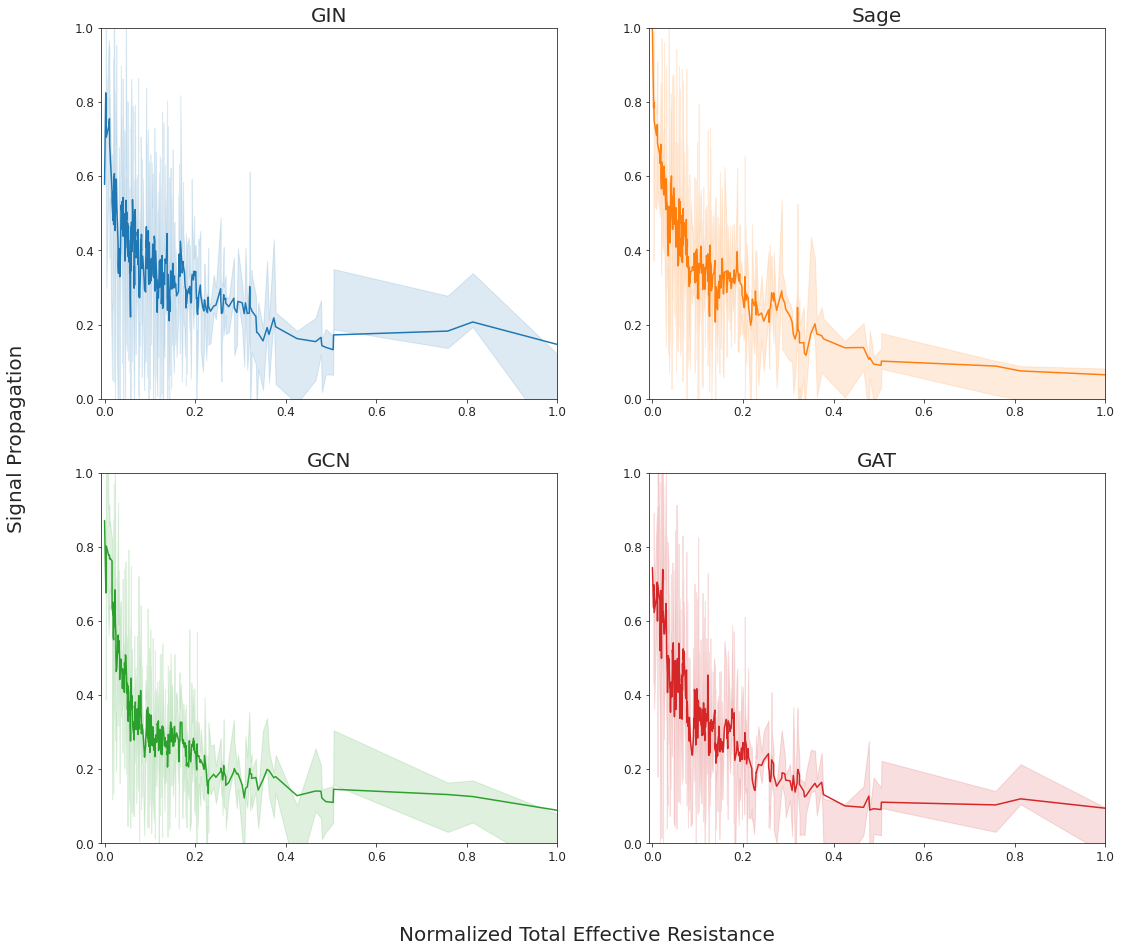

In [8]:

pairs_gin = np.array(pairs_gin)
pairs_gin = pairs_gin[pairs_gin[:, 0].argsort()]


pairs_sage = np.array(pairs_sage)
pairs_sage = pairs_sage[pairs_sage[:, 0].argsort()]


pairs_gcn = np.array(pairs_gcn)
pairs_gcn = pairs_gcn[pairs_gcn[:, 0].argsort()]


pairs_gat = np.array(pairs_gat)
pairs_gat = pairs_gat[pairs_gat[:, 0].argsort()]



fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(18,15))

smooth_plot(x=MinMaxScaler().fit_transform(pairs_gin[:,0].reshape(-1,1)).flatten(), y=MinMaxScaler().fit_transform(pairs_gin[:,1].reshape(-1,1)).flatten(), ax=ax1, halflife=2)



smooth_plot(x=MinMaxScaler().fit_transform(pairs_sage[:,0].reshape(-1,1)).flatten(), y=MinMaxScaler().fit_transform(pairs_sage[:,1].reshape(-1,1)).flatten(), ax=ax2, halflife=2)
smooth_plot(x=MinMaxScaler().fit_transform(pairs_gcn[:,0].reshape(-1,1)).flatten(), y=MinMaxScaler().fit_transform(pairs_gcn[:,1].reshape(-1,1)).flatten(), ax=ax3, halflife=2)
smooth_plot(x=MinMaxScaler().fit_transform(pairs_gat[:,0].reshape(-1,1)).flatten(), y=MinMaxScaler().fit_transform(pairs_gat[:,1].reshape(-1,1)).flatten(), ax=ax4, halflife=2)


# Set common labels
fig.text(0.5, 0.04,  'Normalized Total Effective Resistance', size=20, ha='center', va='center')
fig.text(0.06, 0.5, 'Signal Propagation',  size=20, ha='center', va='center', rotation='vertical')

common_ylim  = (0.0, 1)
common_xlim  = (-0.008, 1)


ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)

ax1.set_ylim(common_ylim)
ax2.set_ylim(common_ylim)
ax3.set_ylim(common_ylim)
ax4.set_ylim(common_ylim)


ax1.set_xlim(common_xlim)
ax2.set_xlim(common_xlim)
ax3.set_xlim(common_xlim)
ax4.set_xlim(common_xlim)



ax1.set_title("GIN",  fontsize=20)
ax2.set_title("Sage",  fontsize=20)
ax3.set_title("GCN", fontsize=20)
ax4.set_title("GAT", fontsize=20)

plt.show()